In [1]:

# --- Setup
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

rng = np.random.default_rng(7)

plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True
})



# Random Networks Beyond Erdős–Rényi

This Colab walks through several random network models and community-detection ideas **beyond** the basic $G(n,p)$.  
It follows the outline from the lecture:
- Configuration model (random wiring with a given degree sequence)  
- p2 (degree-heterogeneity via node effects)  
- Latent-space random graphs  
- Preferential attachment (Barabási–Albert)  

**Dependencies:** `networkx`, `numpy`, `scipy`, `scikit-learn`, `matplotlib`.



## 0) Quick baseline: Erdős–Rényi $G(n,p)$

Edges are independent with probability $p$. Degree concentration is tight, clustering is low, and there is no community structure by design.
We'll use it only as a reference point.


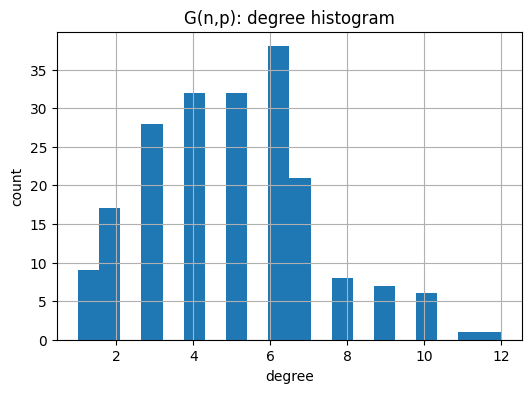

In [2]:

# Small ER demo
n, p = 200, 0.025
G_er = nx.gnp_random_graph(n, p, seed=7)
deg_er = np.array([d for _, d in G_er.degree()])

fig, ax = plt.subplots()
ax.hist(deg_er, bins=20)
ax.set_xlabel("degree")
ax.set_ylabel("count")
ax.set_title("G(n,p): degree histogram")
plt.show()



## 1) Configuration Model

**Goal.** Generate a random network with a *given degree sequence* $\{k_1,\dots,k_n\}$.  
**Construction.** Give node $i$ exactly $k_i$ stubs, then **uniformly pair** all $2L=\sum_i k_i$ stubs (perfect matching).  
This samples uniformly among all multigraphs with that degree sequence.

**Expected adjacency.** For nodes $i\neq j$ with degrees $k_i,k_j$ and $2L=\sum_i k_i$,
\begin{equation}
\mathbb{E}[A_{ij}] \;=\; \frac{k_i k_j}{2L-1} \;\approx\; \frac{k_i k_j}{2L}.
\end{equation}

> This is an **expected edge count** under random stub pairing (a multigraph baseline). It is not a probability and can exceed 1 when both degrees are large.


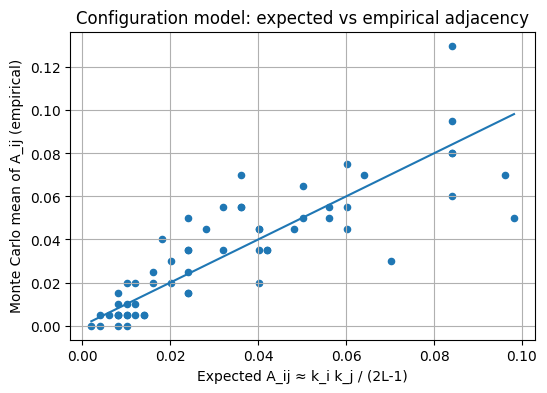

In [3]:

# Helper: sample configuration-model simple graph (collapse multi-edges, remove loops)
def configuration_simple_graph(deg_seq, seed=None):
    M = nx.configuration_model(deg_seq, seed=seed)
    G = nx.Graph(M)
    G.remove_edges_from(nx.selfloop_edges(G))
    return nx.Graph(G)

# Example degree sequence: heterogeneous
n = 120
deg_seq = rng.integers(1, 8, size=n).tolist()  # degrees 1..7
if sum(deg_seq) % 2 == 1:
    deg_seq[0] += 1

G_conf = configuration_simple_graph(deg_seq, seed=7)

# Compare empirical E[A_ij] to baseline ki*kj/(2L-1) on a small subset of pairs
pairs = [(int(rng.integers(0, n)), int(rng.integers(0, n))) for _ in range(300)]
pairs = [(i, j) for i, j in pairs if i < j][:60]

def monte_carlo_mean_Aij(pairs, deg_seq, trials=200, seed=7):
    rng_local = np.random.default_rng(seed)
    counts = {pair: 0 for pair in pairs}
    for t in range(trials):
        Gt = configuration_simple_graph(deg_seq, seed=int(rng_local.integers(0, 1<<31)))
        for i, j in pairs:
            counts[(i, j)] += 1 if Gt.has_edge(i, j) else 0
    return {pair: counts[pair] / trials for pair in pairs}

mc = monte_carlo_mean_Aij(pairs, deg_seq, trials=200, seed=11)
L = sum(deg_seq) // 2
ki = np.array(deg_seq)
exp_baseline = {pair: (ki[pair[0]] * ki[pair[1]]) / (2*L - 1) for pair in pairs}

x = np.array([exp_baseline[p] for p in pairs])
y = np.array([mc[p] for p in pairs])

fig, ax = plt.subplots()
ax.scatter(x, y, s=20)
ax.plot([x.min(), x.max()], [x.min(), x.max()])
ax.set_xlabel("Expected A_ij ≈ k_i k_j / (2L-1)")
ax.set_ylabel("Monte Carlo mean of A_ij (empirical)")
ax.set_title("Configuration model: expected vs empirical adjacency")
plt.show()



## 2) The p2 Model (degree heterogeneity via node effects)

Edges are independent given node effects:
\begin{equation}
\Pr(Y_{ij}=1 \mid \alpha_i,\alpha_j) \;=\; \sigma\!\big(\mu + \alpha_i + \alpha_j\big),\quad \sigma(x)=\frac{1}{1+e^{-x}}.
\end{equation}
Here $\mu$ controls global density and $\alpha_i$ are node-specific "sociability" terms (often zero-mean).  
This reduces to $G(n,p)$ if all $\alpha_i=0$ and induces degree heterogeneity when they vary.


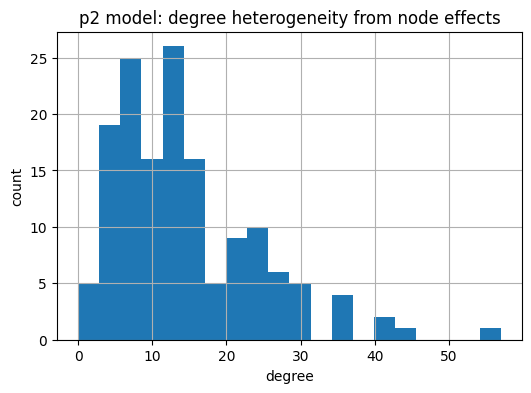

In [4]:

def simulate_p2(n=150, mu=-2.4, sigma_alpha=0.9, seed=7):
    rng = np.random.default_rng(seed)
    alpha = rng.normal(0.0, sigma_alpha, size=n)
    def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
    A = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            p = sigmoid(mu + alpha[i] + alpha[j])
            if rng.random() < p:
                A[i, j] = A[j, i] = 1
    G = nx.from_numpy_array(A)
    return G, alpha

G_p2, alpha = simulate_p2()
deg_p2 = np.array([d for _, d in G_p2.degree()])

fig, ax = plt.subplots()
ax.hist(deg_p2, bins=20)
ax.set_xlabel("degree")
ax.set_ylabel("count")
ax.set_title("p2 model: degree heterogeneity from node effects")
plt.show()



## 3) Latent-Space Random Graphs

Each node $i$ has a position $z_i \in \mathbb{R}^d$ and
\begin{equation}
\Pr(i \sim j) = f(\lVert z_i - z_j\rVert), \quad f \text{ decreasing.}
\end{equation}
This yields clustering (nearby nodes connect) and occasional long links if we allow a flatter tail.


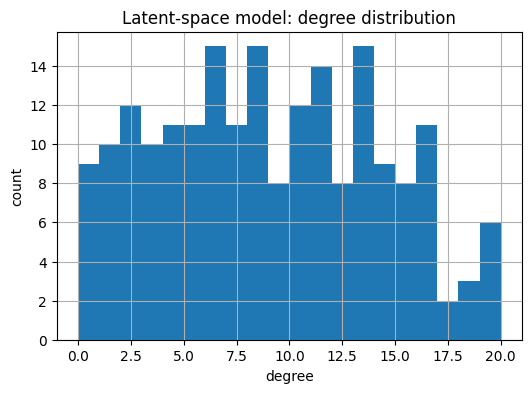

In [5]:

def simulate_latent_space(n=200, d=2, beta0=0.0, beta1=3.0, seed=7):
    rng = np.random.default_rng(seed)
    Z = rng.normal(0.0, 1.0, size=(n, d))
    def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
    A = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(Z[i] - Z[j])
            p = sigmoid(beta0 - beta1 * dist)
            if rng.random() < p:
                A[i, j] = A[j, i] = 1
    return nx.from_numpy_array(A), Z

G_latent, Z = simulate_latent_space()

deg_latent = np.array([d for _, d in G_latent.degree()])
fig, ax = plt.subplots()
ax.hist(deg_latent, bins=20)
ax.set_xlabel("degree")
ax.set_ylabel("count")
ax.set_title("Latent-space model: degree distribution")
plt.show()



## 4) Preferential Attachment (Barabási–Albert)

A growing model where each new node attaches to existing nodes with probability proportional to their current degree.  
This produces heavy-tailed degree distributions with power-law tails (exponent $\gamma \approx 3$ in the BA model).


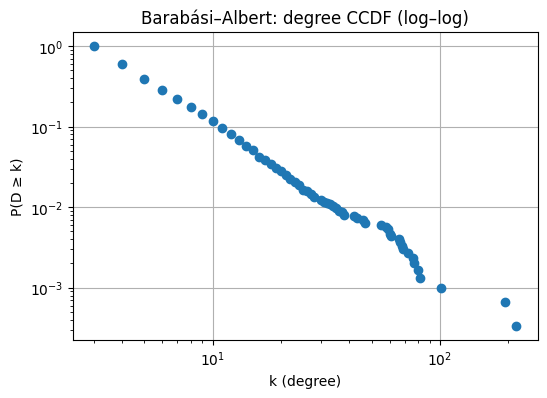

In [6]:

n, m = 3000, 3
G_ba = nx.barabasi_albert_graph(n, m, seed=7)
deg_ba = np.array([d for _, d in G_ba.degree()])

# CCDF on log-log
vals = np.sort(deg_ba)
u, counts = np.unique(vals, return_counts=True)
pmf = counts / counts.sum()
ccdf = 1.0 - np.cumsum(pmf) + pmf  # P(D >= k)

fig, ax = plt.subplots()
ax.loglog(u, ccdf, marker="o", linestyle="")
ax.set_xlabel("k (degree)")
ax.set_ylabel("P(D ≥ k)")
ax.set_title("Barabási–Albert: degree CCDF (log–log)")
plt.show()



## Wrap-up

- **Configuration model** is the random-wiring baseline given degrees; $\mathbb{E}[A_{ij}] \approx k_i k_j/(2L)$ explains why high-degree pairs connect more even without structure.  
- **p2** adds degree heterogeneity via node effects while retaining edge independence.  
- **Latent-space** graphs produce clustering from distances in an unobserved space.  
- **Preferential attachment** explains heavy-tailed degree distributions as a growth mechanism.  

